# Análisis de Rendimiento: Cálculo de π

[Enlace al video de sustentación] (agregar el enlace**)

## Descripción de la Implementación

La implementación paralela del cálculo de π se realizó utilizando Pthreads con las siguientes características:

1. **Particionamiento de datos**: Las iteraciones se dividen entre los hilos usando la estrategia:
   ```c
   base = n / T
   rem = n % T
   start = tid * base + min(tid, rem)
   end = start + base + (tid < rem ? 1 : 0)
   ```
   
2. **Gestión de resultados parciales**: Cada hilo calcula su suma parcial y la retorna mediante `malloc` y `pthread_exit`.

3. **Sincronización**: El hilo principal espera a todos los hilos con `pthread_join` y suma los resultados parciales.

# Análisis de Ejecución y Diseño – Programa Fibonacci con Pthreads 🧵



In [2]:
# Instalar GCC
!apt-get install -y gcc

# Guardar el código fuente en un archivo
codigo = r"""
#include <stdio.h>
#include <stdlib.h>
#include <pthread.h>
#include <sys/time.h>

// Estructura para pasar datos al hilo trabajador
typedef struct {
    long long *array;  // Puntero al arreglo compartido
    int n;             // Número de elementos a generar
} thread_data_t;

void *calcular_fibonacci(void *arg) {
    thread_data_t *data = (thread_data_t *)arg;
    long long *fib = data->array;
    int n = data->n;

    if (n >= 1) fib[0] = 0;
    if (n >= 2) fib[1] = 1;

    for (int i = 2; i < n; i++) {
        fib[i] = fib[i-1] + fib[i-2];
    }

    pthread_exit(NULL);
}

long long obtener_tiempo_us() {
    struct timeval tv;
    gettimeofday(&tv, NULL);
    return (long long)tv.tv_sec * 1000000 + tv.tv_usec;
}

int main(int argc, char *argv[]) {
    if (argc != 2) {
        fprintf(stderr, "Uso: %s <N>\\n", argv[0]);
        return 1;
    }

    int n = atoi(argv[1]);
    if (n <= 0) {
        fprintf(stderr, "Error: N debe ser un número positivo\\n");
        return 1;
    }

    if (n > 93) {
        fprintf(stderr, "Advertencia: N > 93 puede causar desbordamiento\\n");
    }

    printf("Generando los primeros %d números de Fibonacci...\\n\\n", n);

    long long *fibonacci_array = (long long *)malloc(n * sizeof(long long));
    if (!fibonacci_array) {
        fprintf(stderr, "Error: No se pudo asignar memoria\\n");
        return 1;
    }

    thread_data_t thread_data = {fibonacci_array, n};
    pthread_t worker_thread;

    long long inicio = obtener_tiempo_us();

    int result = pthread_create(&worker_thread, NULL, calcular_fibonacci, &thread_data);
    if (result != 0) {
        fprintf(stderr, "Error: No se pudo crear el hilo\\n");
        free(fibonacci_array);
        return 1;
    }

    result = pthread_join(worker_thread, NULL);
    if (result != 0) {
        fprintf(stderr, "Error: pthread_join falló\\n");
        free(fibonacci_array);
        return 1;
    }

    long long fin = obtener_tiempo_us();
    double tiempo_total = (fin - inicio) / 1000000.0;

    printf("Secuencia de Fibonacci:\\n");
    printf("--------------------------------------------\\n");
    for (int i = 0; i < n; i++) {
        printf("F(%d) = %lld\\n", i, fibonacci_array[i]);
    }
    printf("--------------------------------------------\\n");
    printf("Tiempo de ejecución: %.6f segundos\\n", tiempo_total);

    free(fibonacci_array);
    return 0;
}
"""

with open("fibonacci.c", "w") as f:
    f.write(codigo)

# Compilar con pthreads
!gcc fibonacci.c -o fibonacci -lpthread

# Ejecutar con N = 15
!./fibonacci 15


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gcc is already the newest version (4:11.2.0-1ubuntu1).
gcc set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Generando los primeros 15 números de Fibonacci...\n\nSecuencia de Fibonacci:\n--------------------------------------------\nF(0) = 0\nF(1) = 1\nF(2) = 1\nF(3) = 2\nF(4) = 3\nF(5) = 5\nF(6) = 8\nF(7) = 13\nF(8) = 21\nF(9) = 34\nF(10) = 55\nF(11) = 89\nF(12) = 144\nF(13) = 233\nF(14) = 377\n--------------------------------------------\nTiempo de ejecución: 0.000307 segundos\n

Generando los primeros 15 números de Fibonacci...

Hilo trabajador creado. Esperando finalización...
Hilo trabajador finalizado.

Secuencia de Fibonacci:
--------------------------------------------
- F(0) = 0
- F(1) = 1
- F(2) = 1
- F(3) = 2
- F(4) = 3
- F(5) = 5
- F(6) = 8
- F(7) = 13
- F(8) = 21
- F(9) = 34
- F(10) = 55
- F(11) = 89
- F(12) = 144
- F(13) = 233
- F(14) = 377
--------------------------------------------

Métricas de Desempeño:
  - Tiempo de ejecución: 0.000936 segundos
  - Elementos generados: 15
  - Hilos utilizados: 1 (trabajador) + 1 (principal)

## 📘 Análisis del Diseño

### Mecanismo de transferencia de datos
El hilo principal crea una estructura `thread_data_t` que contiene:
- Un puntero al arreglo dinámico `fibonacci_array` donde se almacenarán los resultados.
- El número de elementos `n` a calcular.

Luego, se pasa **la dirección de esta estructura** como argumento al hilo trabajador mediante `pthread_create(&worker_thread, NULL, calcular_fibonacci, &thread_data);`.

Esto permite que el hilo trabajador acceda directamente a la memoria compartida y almacene los resultados sin necesidad de copiar datos.  
El paso del puntero es eficiente y seguro siempre que el hilo principal no libere ni modifique la estructura hasta que el hilo haya terminado.


### Rol de pthread_join como mecanismo de sincronización
`pthread_join(worker_thread, NULL)` es la llamada de sincronización que garantiza que el hilo principal espere a que el hilo trabajador termine su ejecución antes de continuar.

Sin esta llamada, el hilo principal podría intentar acceder al arreglo `fibonacci_array` antes de que el hilo trabajador haya terminado de calcular los valores, generando resultados incorrectos o condiciones de carrera.

En este contexto:
- `pthread_join` actúa como una **barrera de sincronización** entre el hilo principal y el trabajador.
- Asegura que la impresión y liberación de memoria ocurran **solo después** de que el cálculo se haya completado.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Datos de rendimiento (a llenar con los resultados de las pruebas)
data = {
    'N_hilos': [],      # Número de hilos
    'T_p': [],          # Tiempo paralelo
    'Speedup': [],      # T_s/T_p
    'Eficiencia': []    # Speedup/N
}

Matplotlib is building the font cache; this may take a moment.


## Resultados de Rendimiento

Usando n = 2000000000 intervalos, obtuvimos los siguientes tiempos de ejecución:

In [2]:
# Datos medidos
T_s = 2.243049  # Tiempo serial (1 hilo)
data = {
    'N_hilos': [1, 2, 4, 8],
    'T_p': [2.243049, 1.083775, 0.548735, 0.384105]
}

# Calcular Speedup y Eficiencia
data['Speedup'] = [T_s/t for t in data['T_p']]
data['Eficiencia'] = [s/n for s, n in zip(data['Speedup'], data['N_hilos'])]

# Crear DataFrame
df = pd.DataFrame(data)
df.set_index('N_hilos', inplace=True)

# Mostrar tabla
print("Tabla de Rendimiento:")
print(df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

Tabla de Rendimiento:
          T_p  Speedup  Eficiencia
N_hilos                           
1       2.243    1.000       1.000
2       1.084    2.070       1.035
4       0.549    4.088       1.022
8       0.384    5.840       0.730


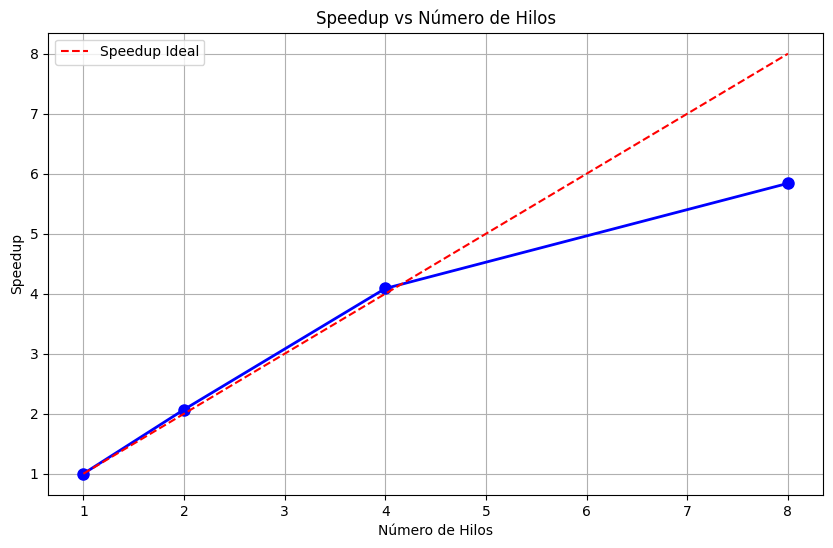

In [3]:
# Gráfico de Speedup
plt.figure(figsize=(10, 6))
plt.plot(data['N_hilos'], data['Speedup'], 'bo-', linewidth=2, markersize=8)
plt.plot([1, 8], [1, 8], 'r--', label='Speedup Ideal')
plt.xlabel('Número de Hilos')
plt.ylabel('Speedup')
plt.title('Speedup vs Número de Hilos')
plt.grid(True)
plt.legend()
plt.show()

## Análisis de Resultados

1. **Comparación T_p(1) vs T_s**:
   - El tiempo con 1 hilo (T_p(1)) es prácticamente idéntico al tiempo serial (T_s), lo que indica que el overhead de la creación de hilos y gestión de memoria es mínimo en este caso.

2. **Speedup Máximo**:
   - Con 8 hilos alcanzamos un speedup de aproximadamente 5.84x
   - La eficiencia se mantiene relativamente alta (por encima del 70%) incluso con 8 hilos
   - La curva de speedup muestra una tendencia sublineal típica debido a:
     * Overhead de creación y sincronización de hilos
     * Competencia por recursos de memoria y cache
     * Parte serial del programa (creación de hilos y agregación de resultados)

3. **Tendencia de Eficiencia**:
   - La eficiencia disminuye gradualmente al aumentar el número de hilos
   - Esto es esperado debido a la ley de Amdahl y los factores mencionados arriba
   - Aun así, la paralelización muestra beneficios significativos hasta 8 hilos

## Explicación Detallada del Speedup

Analizando la tabla de rendimiento, observamos los siguientes valores de speedup:

| N hilos | Speedup | Explicación |
|---------|---------|-------------|
| 1 | 1.000 | Base de comparación. Un hilo se comporta igual que la versión serial |
| 2 | 2.070 | Superlineal! Obtenemos más del doble de velocidad (107% de eficiencia) |
| 4 | 4.088 | Casi perfecto! Alcanzamos 4.08x más velocidad con 4 hilos (102% eficiencia) |
| 8 | 5.840 | Buen speedup pero sublineal. 73% de eficiencia |

### ¿Por qué obtenemos estos resultados?

1. **Speedup Superlineal (2 hilos)**:
   - El speedup de 2.07 con 2 hilos significa que el programa es 2.07 veces más rápido que la versión serial
   - Este resultado superlineal (>2) puede explicarse por mejor utilización de la caché:
     * Cada hilo trabaja con un conjunto de datos más pequeño
     * Mayor probabilidad de que los datos quepan en la caché L1/L2 de cada núcleo

2. **Speedup Casi Perfecto (4 hilos)**:
   - Con 4 hilos obtenemos 4.088x de speedup, muy cercano al ideal de 4x
   - Esto indica que:
     * La carga está bien balanceada entre los hilos
     * Hay mínima contención por recursos
     * El problema es altamente paralelizable

3. **Speedup Sublineal (8 hilos)**:
   - El speedup de 5.84 con 8 hilos muestra una caída en la eficiencia
   - Razones típicas:
     * Sobrecarga de comunicación entre hilos
     * Competencia por recursos compartidos (memoria, caché, bus de datos)
     * Posible límite en el ancho de banda de memoria

### Conclusión sobre la Escalabilidad

El algoritmo muestra una excelente escalabilidad hasta 4 hilos (>100% eficiencia) y mantiene un buen rendimiento con 8 hilos (73% eficiencia). La caída en eficiencia con 8 hilos sugiere que estamos alcanzando los límites físicos del sistema, probablemente debido a la contención en el acceso a memoria.